# ✍️ Descripción breve
En este cuaderno partiremos del dataset df_challenge_meli_limpio.csv, ya depurado e imputado en el notebook de 01_LMEDA_llm_4_data_analisyt, para construir y evaluar modelos de clusterización de vendedores.

Objetivo principal: agrupar sellers según patrones de precio, stock, descuentos, reputación y portafolio de productos, a fin de diseñar estrategias diferenciadas (pricing, promociones, soporte).

Motivación: los análisis previos revelaron relaciones clave (precio ↔ reputación, stock por categoría) y riesgos (outliers, desequilibrios) que se abordarán con escalado robusto y muestreo balanceado cuando sea necesario.

Resultados esperados:

Determinar el número óptimo de clusters (método del codo, silhouette).

Asignar una etiqueta de segmento a cada seller.

In [41]:
import sys
import os
from datetime import date
sys.path.append("C:/Users/dario/Documents/worksapce/sellers_analitycs_meli")
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
)

from meli_insight_engine.llm.agents import rasoner_meli

c:\Users\dario\anaconda3\envs\meli_challenge\Lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.chat_models.openai.ChatOpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


🔍 k óptimo sugerido por KneeLocator: 5


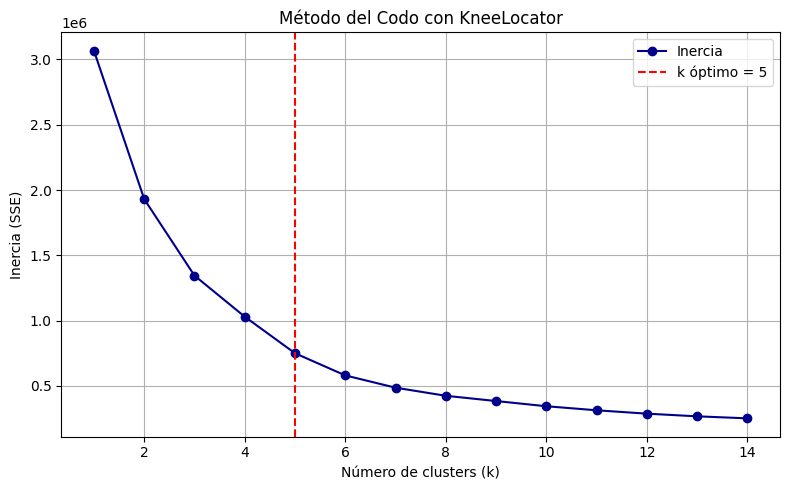

In [25]:

# 1. Cargar dataset limpio transformado
df = pd.read_csv('../data/df_challenge_meli_limpio.csv')
X = df.drop(columns=['seller_nickname'])

# 2. Calcular inercia para varios k
inercia = []
rango_k = range(1, 15)

for k in rango_k:
    modelo = KMeans(n_clusters=k, random_state=42, n_init=10)
    modelo.fit(X)
    inercia.append(modelo.inertia_)

# 3. Encontrar el codo automáticamente
knee = KneeLocator(rango_k, inercia, curve="convex", direction="decreasing")
k_optimo = knee.knee

print(f"🔍 k óptimo sugerido por KneeLocator: {k_optimo}")

# 4. Graficar curva del codo
plt.figure(figsize=(8, 5))
plt.plot(rango_k, inercia, 'o-', color='darkblue', label='Inercia')
if k_optimo is not None:
    plt.axvline(x=k_optimo, color='red', linestyle='--', label=f'k óptimo = {k_optimo}')
plt.title('Método del Codo con KneeLocator')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia (SSE)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [26]:
# ------------------------------------------------------------------
# 0. Cargar dataset limpio + transformado
# ------------------------------------------------------------------
df = pd.read_csv("../data/df_challenge_meli_limpio.csv")
X  = df.drop(columns=["seller_nickname"])

# ------------------------------------------------------------------
# 1. Si k_optimo aún no existe, define uno de respaldo
# ------------------------------------------------------------------
try:
    k_optimo
except NameError:
    k_optimo = None

if k_optimo is None:
    k_optimo = 3  # valor por defecto de respaldo

# ------------------------------------------------------------------
# 2. Entrenar K-Means final y calcular métricas
# ------------------------------------------------------------------
modelo_kmeans = KMeans(n_clusters=k_optimo,
                       random_state=42,
                       n_init=10)
labels = modelo_kmeans.fit_predict(X)

sil  = silhouette_score(X, labels)
db   = davies_bouldin_score(X, labels)
ch   = calinski_harabasz_score(X, labels)

print(f"\n📊 Métricas (k = {k_optimo}):  "
      f"Silhouette={sil:.3f} · DB={db:.3f} · CH={ch:,.0f}")

# ------------------------------------------------------------------
# 3. Añadir columna de cluster y guardar dataset etiquetado
# ------------------------------------------------------------------
df_clustered = df.copy()
df_clustered["cluster"] = labels
out_csv = "../data/df_challenge_meli_clusters.csv"
df_clustered.to_csv(out_csv, index=False)
print(f"✅ Dataset con clusters guardado en {out_csv}")

# ------------------------------------------------------------------
# 4. Guardar el modelo entrenado
# ------------------------------------------------------------------
os.makedirs("models", exist_ok=True)
joblib.dump(modelo_kmeans, "../models/kmeans.pkl")
print("✅ Modelo K-Means guardado en models/kmeans.pkl")

# ------------------------------------------------------------------
# 5. Estadísticas empíricas por cluster
# ------------------------------------------------------------------
num_cols = df_clustered.columns.difference(["seller_nickname", "cluster"])
stats_df = (
    df_clustered
      .groupby("cluster")[num_cols]
      .agg(["mean", "median"])
      .round(2)
)

print("\n=== ESTADÍSTICAS REALES POR CLUSTER ===")
print(stats_df)

# ------------------------------------------------------------------
# 6. Centroides en escala original (si existe pre_pipe.pkl)
# ------------------------------------------------------------------
try:
    pre_pipe = joblib.load("../models/pre_pipe.pkl")   # pipeline imputer + scaler
    centers_orig = pre_pipe.named_steps["scaler"].inverse_transform(
        modelo_kmeans.cluster_centers_
    )
    centroids_df = (
        pd.DataFrame(centers_orig, columns=num_cols)
          .assign(cluster=range(k_optimo))
          .set_index("cluster")
          .round(2)
    )
    print("\n=== CENTROIDES (VALOR ORIGINAL) ===")
    print(centroids_df)
except FileNotFoundError:
    print("\nAviso: 'models/pre_pipe.pkl' no encontrado. "
          "Se omite la tabla de centroides en valores originales.")

# ------------------------------------------------------------------
# 7. Guardar reportes
# ------------------------------------------------------------------
stats_df.to_csv("../data/cluster_stats_empiricas.csv")
if "centroids_df" in locals():
    centroids_df.to_csv("..data/centroides_valores_originales.csv")


📊 Métricas (k = 5):  Silhouette=0.582 · DB=0.612 · CH=35,992
✅ Dataset con clusters guardado en ../data/df_challenge_meli_clusters.csv
✅ Modelo K-Means guardado en models/kmeans.pkl

=== ESTADÍSTICAS REALES POR CLUSTER ===
        categorias_distintas        log_price_avg        log_stock_avg         \
                        mean median          mean median          mean median   
cluster                                                                         
0                       0.46    0.0          0.22   0.06          0.13  -0.09   
1                      22.25   21.0          0.15   0.25          0.62   0.69   
2                      12.24   10.5          0.09   0.13          0.21   0.21   
3                       5.65    4.0          0.04  -0.05          0.33   0.19   
4                       0.85    0.0         -0.40  -0.51          0.59   0.58   

        num_publicaciones         porc_descuento        proporcion_refurb  \
                     mean  median           mean m

NotFittedError: This RobustScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

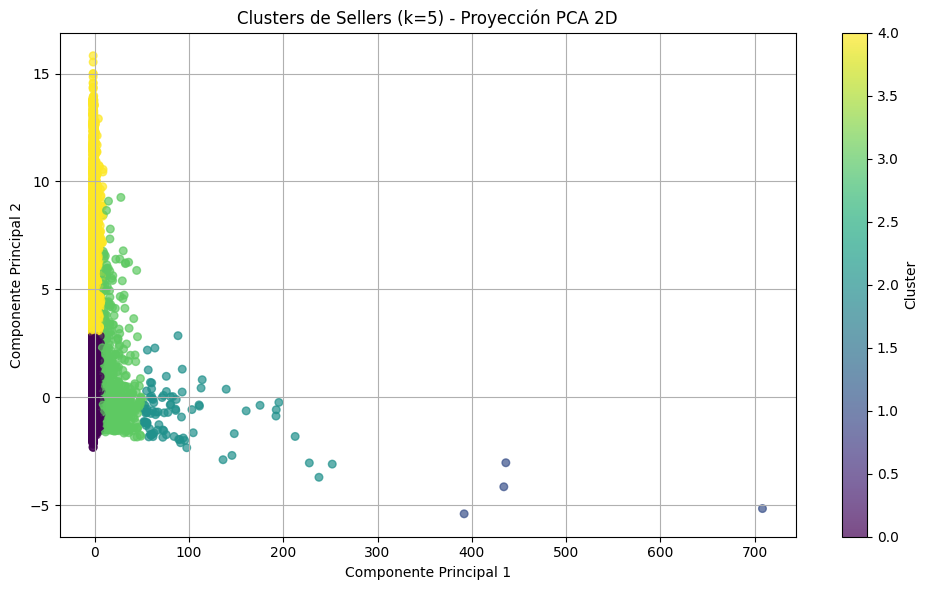

In [27]:

# 1. Aplicar PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

# 2. Visualizar los clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=df_clustered['cluster'],
    cmap='viridis',
    s=30, alpha=0.7
)
plt.title(f'Clusters de Sellers (k={k_optimo}) - Proyección PCA 2D')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()


In [28]:
# -----------------------------------------------------------
# 5. Analizar qué variables conforman PC1 y PC2
# -----------------------------------------------------------
from sklearn.decomposition import PCA

# a) Ajustar PCA en los datos escalados (X ya está listo)
pca = PCA(n_components=2, random_state=42).fit(X)

# b) Cargar las 'loadings' en un DataFrame legible
loadings = (pd.DataFrame(
                pca.components_.T,          # matriz p×2
                columns=['PC1', 'PC2'],
                index=X.columns)            # nombres de las variables
            .round(3)                       # opcional, redondear
)

# c) Ver las variables más influyentes de cada componente
print("\n🔹 Top variables en PC1:")
print(loadings['PC1'].abs().sort_values(ascending=False).head(5))

print("\n🔹 Top variables en PC2:")
print(loadings['PC2'].abs().sort_values(ascending=False).head(5))

# d) (Opcional) exportar a CSV para consultarlo fuera del notebook
loadings.to_csv("../data/pca_loadings.csv")



🔹 Top variables en PC1:
num_publicaciones       0.991
categorias_distintas    0.133
rep_score               0.013
titulo_length_avg       0.010
log_price_avg           0.004
Name: PC1, dtype: float64

🔹 Top variables en PC2:
porc_descuento          0.980
titulo_length_avg       0.104
log_price_avg           0.096
rep_score               0.082
categorias_distintas    0.077
Name: PC2, dtype: float64


### Metricas del cluster 

In [15]:
def quality_metrics(X, k):
    km = MiniBatchKMeans(n_clusters=k, random_state=42).fit(X)
    labels = km.labels_
    return {
        "k": k,
        "silhouette": silhouette_score(X, labels),
        "davies_bouldin": davies_bouldin_score(X, labels),
        "calinski_harabasz": calinski_harabasz_score(X, labels),
        "inertia": km.inertia_,
    }

results = [quality_metrics(X, k) for k in range(2, 11)]
pd.DataFrame(results).set_index("k")

KeyboardInterrupt: 

### ¿Qué hacemos con estos segmentos de vendedores?

| Segmento (nuestro nombre)                              | ¿Por qué es importante?                                         | Acciones clave que la plataforma puede tomar                                                                                                                                                           | Éxito se mide en…                                                                      |
| ------------------------------------------------------ | --------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ | -------------------------------------------------------------------------------------- |
| **Power Sellers Premium**<br>(muy pocos, pero grandes) | Generan gran parte del GMV con excelente reputación.            | *Mimar y retener*<br>• Comisiones preferenciales por volumen.<br>• Acceso prioritario a logística Fulfillment.<br>• Créditos en anuncios y pruebas de nuevas funciones.                                | → GMV que crece trimestre a trimestre.<br>→ Fidelidad (que no migren a otros canales). |
| **Sellers Consolidados**                               | Tienen buen tamaño y reputación, pero aún pueden crecer.        | *Impulsar crecimiento*<br>• “Paquete de crecimiento”: asesor comercial + saldo inicial en Ads.<br>• Bonificación de comisión si cumplen metas de entrega.                                              | → % que ascienden a Premium.<br>→ Incremento de gasto en Ads.                          |
| **Cazadores de Oferta**                                | Venden gracias a grandes descuentos; buen volumen, bajo margen. | *Subir margen sin perder ventas*<br>• Herramienta que sugiere el descuento óptimo.<br>• Cupos en campañas Flash Sale condicionados a margen mínimo.                                                    | → Margen por venta.<br>→ Conversiones en campañas relámpago.                           |
| **Liquidadores / Outlet**                              | Mucho stock rebajado, quieren vaciar inventario rápido.         | *Acelerar rotación*<br>• Canal de Liquidaciones con envíos a tarifa plana.<br>• Cupones automáticos fin de mes.                                                                                        | → Días de inventario.<br>→ % de stock liquidado cada mes.                              |
| **Sellers Ocasionales**                                | Son la mayoría, catálogo pequeño, reputación baja.              | *Educar y filtrar*<br>• Ruta de onboarding guiada (vídeos, plantillas).<br>• Micro-créditos para comprar stock si mejoran sus métricas.<br>• Alertas automáticas sobre tiempos de despacho y reclamos. | → Cuántos pasan a Consolidados.<br>→ Tasa de reclamos < 2 %.                           |


### Clusterización de Sellers: Asignación de Segmento Comercial
En esta celda se realiza el proceso de **clusterización** de los vendedores utilizando el algoritmo K-Means, a partir de sus principales métricas de negocio (como número de publicaciones, stock promedio, reputación, descuentos, etc.).  
El objetivo es identificar grupos o segmentos homogéneos de sellers, como Power Sellers, en Crecimiento u Ocasionales, para facilitar la segmentación y la toma de decisiones comerciales personalizadas por parte del equipo de Mercado Libre.


In [33]:
import pandas as pd
import joblib

# 1. Cargar artefactos
pre_pipe = joblib.load("../models/pre_pipe.pkl")
kmeans   = joblib.load("../models/kmeans.pkl")

# 2. Tomar el orden que el pipeline espera
FEATURES = list(pre_pipe.feature_names_in_)
print("Orden esperado:", FEATURES)
# → ['categorias_distintas', 'log_price_avg', 'log_stock_avg',
#    'num_publicaciones', 'porc_descuento', 'proporcion_refurb',
#    'proporcion_usados', 'rep_score', 'titulo_length_avg']

CLUSTER_NAME = {
    1: "Power Sellers",
    2: "Sellers en Crecimiento",
    0: "Sellers Ocasionales",
    3: "Cazadores de Oferta",
    4: "Liquidadores / Outlet",
}

def clasificar_seller(metrics: dict) -> dict:
    """metrics contiene las 9 métricas numéricas del vendedor."""
    X = pd.DataFrame([metrics])[FEATURES]   # columnas en el orden correcto
    X_prep = pre_pipe.transform(X)          # ya no lanza error
    cid    = int(kmeans.predict(X_prep)[0])
    return {"cluster_id": cid,
            "cluster_name": CLUSTER_NAME.get(cid, "Desconocido")}

# Ejemplo
nuevo = {
    "categorias_distintas": 15,
    "log_price_avg":       11.55,
    "log_stock_avg":       4.82,
    "num_publicaciones":   120,
    "porc_descuento":      0.27,
    "proporcion_refurb":   0.0,
    "proporcion_usados":   0.0,
    "rep_score":           4.1,
    "titulo_length_avg":   30,
}

print(clasificar_seller(nuevo))
# → {'cluster_id': 2, 'cluster_name': 'Sellers en Crecimiento'}


Orden esperado: ['categorias_distintas', 'log_price_avg', 'log_stock_avg', 'num_publicaciones', 'porc_descuento', 'proporcion_refurb', 'proporcion_usados', 'rep_score', 'titulo_length_avg']
{'cluster_id': 2, 'cluster_name': 'Sellers en Crecimiento'}


c:\Users\dario\anaconda3\envs\meli_challenge\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


### COT: Chains of Thought Enriquecido
Esta celda corresponde a la implementación de una Chain of Thought (COT) enriquecida con contexto de negocio y estacionalidad para Mercado Libre.
Utiliza un flujo de razonamiento secuencial (LangChain SequentialChain) que:

Paso 1: Identifica automáticamente el contexto externo relevante para la fecha actual (ejemplo: campañas comerciales, temporadas altas o bajas, eventos masivos, etc.).

Paso 2: Genera una estrategia comercial personalizada, considerando simultáneamente:

El segmento al que pertenece el seller (cluster)

Sus métricas clave de negocio

El contexto estacional detectado

De este modo, el equipo comercial obtiene recomendaciones realmente adaptadas, no solo al perfil de cada vendedor, sino también al momento del año y a las oportunidades del entorno.

In [42]:

# Ejemplo de entrada:
input_payload = {
    "fecha_actual":         date.today().isoformat(),
    "cluster_name":         "Seller en Crecimiento",
    "publicaciones":        120,
    "categorias_distintas": 15,
    "stock_promedio":       124,
    "precio_medio_cop":     105_000,
    "descuento_pct":        0.27,
    "rep_score":            4.1,
    "tasa_cancelacion":     0.8,
}

output = rasoner_meli.cot_chain(input_payload)

print("Contexto de temporada detectado:", output["temporada"])
print("Recomendación personalizada:\n", output["estrategia"])


c:\Users\dario\anaconda3\envs\meli_challenge\Lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


Contexto de temporada detectado: - Vacaciones mitad de año  

Razonamiento: Agosto es un mes típico de vacaciones escolares en Colombia, lo que impulsa compras relacionadas con viajes, entretenimiento y productos para niños.
Recomendación personalizada:
 **Acción prioritaria: Optimizar el mix de productos y promociones enfocadas en vacaciones escolares**  

Dado que el vendedor es **Seller en Crecimiento** y agosto es temporada de vacaciones en Colombia, recomiendo:  

1. **Enfocar el 30% del stock en categorías clave para vacaciones**:  
   - Priorizar productos como juegos de viaje, electrónica portátil (audífonos, power banks), artículos para niños (juguetes, mochilas) y deportes al aire libre.  
   - Ajustar descuentos (reducir al 20-25% en productos de alta demanda para proteger margen) y destacarlos en títulos/publicaciones con palabras clave como "vacaciones" o "viaje".  

2. **Reducir cancelaciones (80% es crítico)**:  
   - Verificar stock real vs. publicado y actualizar autom